# **Deep Learning Project: Garbage Classification - Grid Search**

My approach to model creation involved dividing my work into several notebooks, each dedicated to specific types of data and models. I had one notebook for pre-trained models, and two for custom models—one for 50x50 pixel size images and another for 128x128. I then consolidated the top-performing models from each category into a notebook named 'Best Models.' Finally, I conducted a manual grid search in a separate notebook to further optimize the best-performing models.

This notebook includes the last steps I conducted: the Grid Search and the evaluation on the test set.

## 1. Import Libraries

In [134]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
import itertools
import time
import random
import seaborn as sns

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Metric

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical


## 2. Import the splited data

In [2]:
def load_data_from_directory(directory):
    # Lists to store the file paths as well as the labels of the images
    file_paths = []
    class_labels = []
    # Walk through the directory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir = "./resized and split 50/train_test_val_50"
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'test')
val_dir = os.path.join(split_dir, 'validation')

# Load data
train_paths, train_labels, class_to_idx = load_data_from_directory(train_dir)
test_paths, test_labels, _ = load_data_from_directory(test_dir)
val_paths, val_labels, _ = load_data_from_directory(val_dir)

# Verify the data
print(f"Loaded {len(train_paths)} training samples.")
print(f"Loaded {len(test_paths)} testing samples.")
print(f"Loaded {len(val_paths)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


## 3. Defining needed variables

In [4]:
# Define the image size for resizing
img_size = (50, 50)
# Specify the label mode for categorical classification
label_mode = "categorical"
# Set random seed for NumPy to ensure reproducibility
np.random.seed(42)
# Set random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(42)

## 4. Data Augmentation

I'm implementing data augmentation in the training dataset so that the model can see different images produced from the original one across epochs. I'm also resizing images so that the pixel values range from 0 to 1.

When I create the train_generator using flow_from_dataframe, I'm not pre-generating all batches of images with their transformations. What I'm doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

In [5]:
# Define the image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=45,           # Randomly rotate images in the range (0, 45 degrees)
    width_shift_range=0.1,       # Randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,      # Randomly shift images vertically (10% of total height)
    shear_range=0.1,             # Apply shear transformations
    zoom_range=0.2,              # Randomly zoom image in and out (20% zoom)
    horizontal_flip=True,        # Randomly flip images horizontally
    brightness_range=[0.8, 1.2], # Randomly change brightness (80-120% of original value)
    fill_mode='nearest'          # Fill in new pixels after a transformation
)
   
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [148]:
# Generate batches of augmented training data from the directory
train_generator_32 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 50x50
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

# Generate batches of validation data from the directory
validation_generator_32 = val_test_datagen.flow_from_directory(
    val_dir,  # Directory containing the validation images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=32,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

# Generate batches of test data from the directory
test_generator_32 = val_test_datagen.flow_from_directory(
    test_dir,  # Directory containing the validation images
    target_size=img_size,  # Resize images to the specified dimensions
    batch_size=32,  # Number of samples per batch
    class_mode=label_mode  # Type of labels provided 
)

# Assign the directory of the test generator for images of size 50x50 pixels to the variable test_generator_dir_50
test_generator_dir_50 = test_generator_32.directory

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.
Found 1241 images belonging to 12 classes.


## 5. Weights
Compute class weights to address class imbalance, enhancing model performance in classification tasks.

In [9]:
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight = 'balanced',                       # Set class weights to 'balanced'
    classes = np.unique(train_generator_32.classes), # Unique classes in the training data
    y = train_generator_32.classes                   # Actual class labels of the training data
)


In [10]:
# Create a dictionary mapping class indices to their respective class weights
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.3681657848324515,
 1: 1.3126057529610828,
 2: 2.128257887517147,
 3: 1.4506778868630201,
 4: 0.24280125195618155,
 5: 2.0563286944996686,
 6: 1.6818428184281842,
 7: 1.2313492063492064,
 8: 1.4947013487475915,
 9: 0.6538137378845343,
 10: 1.8569718731298623,
 11: 1.668279569892473}

## 6. CALLBACKS

In [11]:
# Define the directory to save model checkpoints
checkpoint_dir = "./Callbacks_50"
# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a function to create callbacks for model training
def create_model_callbacks(model_name):
    # Create a directory specific to the model
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    # Define a ModelCheckpoint callback to save the best model weights based on validation F1 score
    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.weights.h5'),  # Save path for best model weights
        save_best_only=True,                    # Save only the best model weights
        save_weights_only=True,                 # Save only the model weights
        monitor='val_f1_score',                 # Monitor validation F1 score for saving the best model
        mode='max',                             # Set mode to maximize the F1 score
        verbose=1                               # Display progress updates
    )
    
    # Define an EarlyStopping callback to stop training if validation F1 score does not improve
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',                 # Monitor validation F1 score for early stopping
        patience=3,                             # Number of epochs with no improvement before stopping
        mode='max',                             # Set mode to maximize the F1 score
        verbose=1                               # Display progress updates
    )
    
    # Define a ReduceLROnPlateau callback to reduce learning rate if validation F1 score does not improve
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',                 # Monitor validation F1 score for learning rate reduction
        factor=0.75,                            # Factor by which to reduce the learning rate
        patience=2,                             # Number of epochs with no improvement before reducing learning rate
        mode='min',                             # Set mode to minimize the F1 score
        verbose=1,                              # Display progress updates
        min_lr=0.0001                           # Minimum learning rate threshold
    )

    # Return a list of callbacks
    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]

## 7. Defining functions to check the model performance

In [12]:
# Define a custom F1 Score metric class
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        # Initialize the metric name and any additional arguments
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize variables to keep track of true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert true and predicted labels to boolean tensors
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5)  # Adjust the threshold 
        # Calculate true positives, false positives, and false negatives
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        # Update the counts of true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # Calculate F1 score
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    def reset_states(self):
        # Reset the counts of true positives, false positives, and false negatives to zero
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)# Define a custom F1Score metric class
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize weights to track true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    # Update state based on true labels and predicted labels
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert labels to boolean values
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5) 
        # Calculate true positives, false positives, and false negatives
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        
        # Update weights with the sums of true positives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    # Calculate F1 score based on current state
    def result(self):
        # Calculate precision and recall
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        # Calculate F1 score
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    # Reset state to initial values
    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [144]:
def eval_model_size50_batch32(model, eval_dir=[], eval_name=[]):
    # List to store confusion matrices for each evaluation
    confusion_matrices = []
    
    # Iterate over each evaluation directory and name
    for i in range(len(eval_dir)):
        print(f"##### Evaluating the model for {eval_name[i]} #####")
        
        # Create a data generator for evaluation
        eval_generator = val_test_datagen.flow_from_directory(
            eval_dir[i],                       
            target_size=(50, 50),             
            batch_size=32,                    
            shuffle=False,                    
            class_mode='categorical'           
        )
        
        # Calculate the number of evaluation steps per epoch
        eval_steps_per_epoch = np.math.ceil(eval_generator.samples / eval_generator.batch_size)

        # Generate predictions using the model
        predictions = model.predict(eval_generator, steps=eval_steps_per_epoch)
        
        # Get the index of the class with the highest probability for each prediction
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the true classes from the generator
        true_classes = eval_generator.classes
        
        # Get the class labels from the generator
        class_labels = list(eval_generator.class_indices.keys())

        # Generate a classification report
        report = classification_report(true_classes, predicted_classes, target_names=class_labels)
        
        # Print the classification report
        print(report)



In [145]:
def plot_confusion_heatmap(model, eval_dir=[], eval_name=[]):
    # List to store confusion matrices for each evaluation
    confusion_matrices = []
    
    # Iterate over each evaluation directory and name
    for i in range(len(eval_dir)):
        # Print a header for the evaluation
        print(f"##### Evaluating the model for {eval_name[i]} #####")
        
        # Create a data generator for evaluation
        eval_generator = val_test_datagen.flow_from_directory(
            eval_dir[i],                       
            target_size=(50, 50),             
            batch_size=32,                    
            shuffle=False,                    
            class_mode='categorical'           
        )
        
        # Calculate the number of evaluation steps per epoch
        eval_steps_per_epoch = np.math.ceil(eval_generator.samples / eval_generator.batch_size)

        # Generate predictions using the model
        predictions = model.predict(eval_generator, steps=eval_steps_per_epoch)
        
        # Get the index of the class with the highest probability for each prediction
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the true classes from the generator
        true_classes = eval_generator.classes
        
        # Get the class labels from the generator
        class_labels = list(eval_generator.class_indices.keys())

        # Generate confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        # Store confusion matrix in the list
        confusion_matrices.append(cm)
        
    # Convert the list of confusion matrices to DataFrame
    df_confusion_matrices = pd.DataFrame(confusion_matrices[0], index=class_labels, columns=class_labels)
    
    # Create heatmap with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_confusion_matrices, annot=True, fmt='d', cmap='Blues')  
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [93]:
def plot_wrong_classifications(model, test_directories, eval_names):
    for test_directory, eval_name in zip(test_directories, eval_names):
        # Create a data generator for the test data
        test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values
        test_generator = test_datagen.flow_from_directory(
            test_directory,                      # Test data directory
            target_size=(50, 50),                # Resize images to 50x50 pixels
            batch_size=32,                       # Batch size for evaluation
            shuffle=False,                       # Set the shuffle to false
            class_mode='categorical'             # Use categorical labels
        )

        # Get the true classes from the generator
        true_classes = test_generator.classes

        # Get the class labels from the generator
        class_labels = list(test_generator.class_indices.keys())

        # Generate predictions using the model
        predictions = model.predict(test_generator)

        # Get the index of the class with the highest probability for each prediction
        predicted_classes = np.argmax(predictions, axis=1)

        # Find misclassified images
        misclassified_indices = np.where(predicted_classes != true_classes)[0]

        # Select a random subset of misclassified indices
        random.shuffle(misclassified_indices)
        misclassified_indices = misclassified_indices[:3]  # Select only 3 images

        # Plot misclassified images horizontally
        plt.figure(figsize=(10, 5))  # Set figure size
        for i, idx in enumerate(misclassified_indices):
            # Get the true and predicted labels
            true_label = class_labels[true_classes[idx]]
            predicted_label = class_labels[predicted_classes[idx]]

            # Load the misclassified image
            img = plt.imread(test_generator.filepaths[idx])

            # Plot the image
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.title(f'Evaluation: {eval_name}\nTrue label: {true_label}\nPredicted label: {predicted_label}')
            plt.axis('off')

        plt.tight_layout()  
        plt.show()


In [15]:
# Function to plot the F1 and Loss values for both train and validation
def plot_training_history(history):
    # Convert training history to DataFrame
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    # Create subplots for loss and F1 score curves
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha=1.0)
    ax1.set_ylim([0, 2])  # Set y-axis limits for loss

    # Plot F1 score curves
    ax2 = df_hist.plot(x="Epoch", y=['f1_score', 'val_f1_score'],
                       kind="line", grid=True, legend=True,
                       ylabel="F1 Score", 
                       xlabel="Epoch", title="F1 Score curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])  # Set y-axis limits for F1 score



In [16]:
# Function to extract accuracy, F1 Score, and loss, from a given training history based on a specified metric (F1 as default)
def get_metrics(rec, metric='f1_score'):
    # Find the index of the best validation accuracy
    index = np.argmax(rec.history[metric])
    
    # Extract scores based on the index
    acc = rec.history["accuracy"][index]
    f1 = rec.history["f1_score"][index]
    loss = rec.history["loss"][index]
    val_acc = rec.history["val_accuracy"][index]
    val_f1 = rec.history["val_f1_score"][index]
    val_loss = rec.history["val_loss"][index]

    return acc, f1, loss, val_acc, val_f1, val_loss

In [17]:
# Function to compile the model with Adam optimizer
def compile_model_adam(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

In [18]:
# Function to compile the model with SGD optimizer
def compile_model_SGD(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

## 8. Train the best model

#### After I tested different models, I chose the model with best perfomance 

In [150]:
model_non_linear_50 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer

    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(512, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Conv2D(1024, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(2, 2),  # Max pooling layer

    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(256, activation='relu'),  # Dense layer with ReLU activation
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.2),  # Dropout layer for regularization

    Dense(train_generator_32.num_classes, activation='softmax')  # Output layer with softmax activation
])

model_non_linear_50.summary()  # Display model summary

c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 3, 3, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,829,260 (26.05 MB)

 Trainable params: 6,824,204 (26.03 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [151]:
# Adam optimizer and batch size 32

# Create callbacks for the model
callbacks = create_model_callbacks("history_non_linear_50_1")  # Callbacks for model training
model_non_linear_50_1 = compile_model_adam(model_non_linear_50) # Compile the model with Adam optimizer

# Train the model
history_non_linear_50_1 = model_non_linear_50_1.fit(    
    train_generator_32,  # Training data generator 32 batch size 
    epochs=50,  # Number of epochs
    validation_data=validation_generator_32, # Validation data generator
    callbacks=callbacks # Callbacks to be applied during training
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4565 - f1_score: 0.4310 - loss: 1.8608
Epoch 1: val_f1_score improved from -inf to 0.26437, saving model to ./Callbacks_50\history_non_linear_50_1\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 77s 186ms/step - accuracy: 0.4567 - f1_score: 0.4311 - loss: 1.8601 - val_accuracy: 0.2943 - val_f1_score: 0.2644 - val_loss: 2.8139 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5861 - f1_score: 0.5774 - loss: 1.2736
Epoch 2: val_f1_score improved from 0.26437 to 0.59273, saving model to ./Callbacks_50\history_non_linear_50_1\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 73s 187ms/step - accuracy: 0.5862 - f1_score: 0.5774 - loss: 1.2736 - val_accuracy: 0.5747 - val_f1_score: 0.5927 - val_loss: 1.3945 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6384 - f1_score: 0.6309 - loss: 1.1043
Epoch 3: val_f1_score did not improve from 0.59

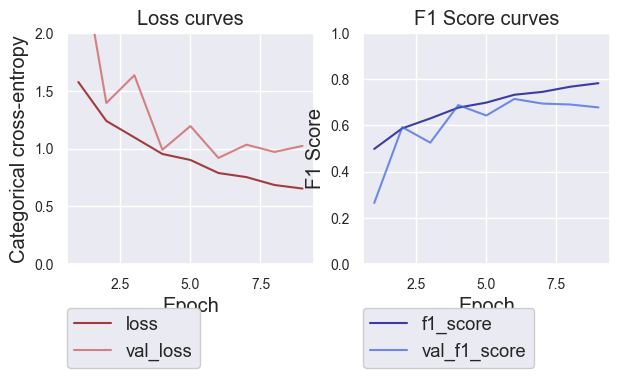

In [152]:
# Plotting the results
plot_training_history(history_non_linear_50_1)

In [162]:
# Extracting evaluation metrics
acc_non_linear_50_1, f1_non_linear_50_1, loss_non_linear_50_1, val_acc_non_linear_50_1, val_f1_non_linear_50_1, val_loss_non_linear_50_1 = get_metrics(history_non_linear_50_1)

# Print the metrics 
print("Training Accuracy:", acc_non_linear_50_1)
print("Training F1 Score:", f1_non_linear_50_1)
print("Training Loss:", loss_non_linear_50_1)
print("Validation Accuracy:", val_acc_non_linear_50_1)
print("Validation F1 Score:", val_f1_non_linear_50_1)
print("Validation Loss:", val_loss_non_linear_50_1)

Training Accuracy: 0.7831131219863892
Training F1 Score: 0.7829121947288513
Training Loss: 0.6535009741783142
Validation Accuracy: 0.6756176352500916
Validation F1 Score: 0.6780257821083069
Validation Loss: 1.0230298042297363


### 8.1 Grid Search

#### In this step, I performed a grid search with different parameters like optimizers, droupout rates and class weights to achieve a better perfomance in the model

In [153]:
# Parameters values to search
optimizers_50 = ['adam', 'sgd']  # List of optimizers to search
dropout_rates_50 = [0.1, 0.2, 0.3]  # List of dropout rates to search
class_weights_50 = [True, False]  # List of class weights to search

best_model_50 = None  # Initialize variable to store the best model
best_model_history = None  # Initialize variable to store the history of the best model
best_val_f1_score_50 = 0  # Initialize variable to store the best validation F1 score
best_params_50 = {}  # Initialize dictionary to store the parameters of the best model

results_50 = []  # Initialize list to store results of each model evaluation

# Function to create model with fixed architecture and learning rate scheduler callback
def create_model_50(optimizer, dropout_rate):
    # Define the architecture of the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3), padding='same'), # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer

        Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        MaxPooling2D(2, 2), # Max pooling layer

        Conv2D(128, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        MaxPooling2D(2, 2), # Max pooling layer

        Conv2D(256, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        MaxPooling2D(2, 2), # Max pooling layer

        Conv2D(512, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        MaxPooling2D(2, 2), # Max pooling layer

        Conv2D(1024, (3, 3), activation='relu', padding='same'), # Convolutional layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        MaxPooling2D(2, 2), # Max pooling layer

        Flatten(), # Flatten layer to convert 2D feature maps to 1D feature vectors
        Dense(512, activation='relu'), # Dense layer with ReLU activation
        BatchNormalization(), # Batch normalization layer
        Dropout(dropout_rate), # Dropout layer for regularization

        Dense(train_generator_32.num_classes, activation='softmax') # Output layer with softmax activation
    ])
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1Score()])
    
    return model

In [154]:
# Perform grid search
for optimizer, dropout_rate, use_class_weights in itertools.product(optimizers_50, dropout_rates_50, class_weights_50):
    # Create a model name based on the current optimizer, dropout rate, and class weights
    model_name = f"model with {optimizer} optimizer and a dropout rate of {dropout_rate} and with class_weights = {use_class_weights}"
    print(f"Training {model_name}...")
    
    # Record the start time of training
    start_time = time.time()
    
    # Create the model with the specified optimizer and dropout rate
    model = create_model_50(optimizer, dropout_rate)
    
    # Create callbacks for the model
    callbacks = create_model_callbacks(f"model_{optimizer}_{dropout_rate}_{use_class_weights}")
    
    # Train the model
    if use_class_weights:
        # If using class weights, pass them to the fit function
        history = model.fit(train_generator_32, epochs=50, validation_data=validation_generator_32, callbacks=callbacks, class_weight=class_weights_dict)
    else:
        # Otherwise, train without class weights
        history = model.fit(train_generator_32, epochs=50, validation_data=validation_generator_32, callbacks=callbacks)
    
    # Record the end time of training
    end_time = time.time()
    
    # Evaluate the model on the training and validation sets
    train_loss, train_accuracy, train_f1_score = model.evaluate(train_generator_32)
    val_loss, val_accuracy, val_f1_score = model.evaluate(validation_generator_32)
    
    # Record the results
    results_50.append({'optimizer': optimizer,
                    'dropout_rate': dropout_rate,
                    'use_class_weights': use_class_weights,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'train_f1_score': train_f1_score,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'val_f1_score': val_f1_score,
                    'training_time': end_time - start_time})
    
    # Check if the current validation F1 score is better than the best so far
    if val_f1_score > best_val_f1_score_50:
        # If so, update the best validation F1 score, best model, best model history, and best parameters
        best_val_f1_score_50 = val_f1_score
        best_model_50 = model
        best_model_history_50 = history
        best_params_50 = {'optimizer': optimizer,
                       'dropout_rate': dropout_rate,
                       'use_class_weights': use_class_weights}

# Print the best validation F1 score and the corresponding best parameters
print("Best Validation F1 Score:", best_val_f1_score_50)
print("Best Parameters:", best_params_50)


Training model with adam optimizer and a dropout rate of 0.1 and with class_weights = True...
Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3734 - f1_score: 0.3200 - loss: 2.0342
Epoch 1: val_f1_score improved from -inf to 0.15026, saving model to ./Callbacks_50\model_adam_0.1_True\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.3735 - f1_score: 0.3202 - loss: 2.0335 - val_accuracy: 0.1826 - val_f1_score: 0.1503 - val_loss: 3.4370 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5077 - f1_score: 0.4652 - loss: 1.4661
Epoch 2: val_f1_score improved from 0.15026 to 0.42342, saving model to ./Callbacks_50\model_adam_0.1_True\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 70s 180ms/step - accuracy: 0.5078 - f1_score: 0.4652 - loss: 1.4660 - val_accuracy: 0.4232 - val_f1_score: 0.4234 - val_loss: 2.0324 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5577 - f1_score: 0.5270 - loss: 1.3490
Epoch 3: val_f1_score improved from 0.42342 to 0.52501,

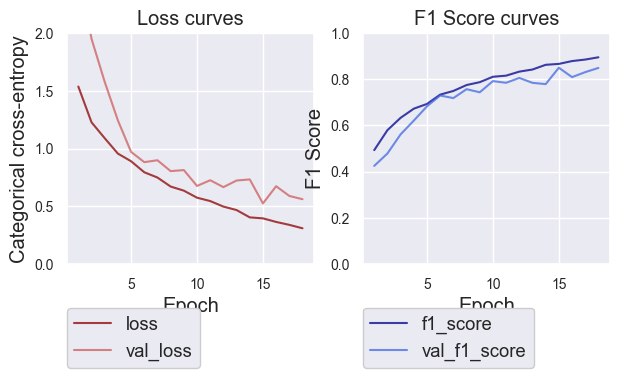

In [157]:
# Plot training history
plot_training_history(best_model_history_50)

In [158]:
# Extracting evaluation metrics
best_acc_50, best_f1_50, best_loss_50, best_val_acc_50, best_val_f1_50, best_val_loss_50 = get_metrics(best_model_history_50)

# Print the metrics 
print("Training Accuracy:", best_acc_50)
print("Training F1 Score:", best_f1_50)
print("Training Loss:", best_loss_50)
print("Validation Accuracy:", best_val_acc_50)
print("Validation F1 Score:", best_val_f1_50)
print("Validation Loss:", best_val_loss_50)


Training Accuracy: 0.8942152857780457
Training F1 Score: 0.8951048254966736
Training Loss: 0.30963844060897827
Validation Accuracy: 0.8426423072814941
Validation F1 Score: 0.8490513563156128
Validation Loss: 0.5614079833030701


# 9. Evaluation the model in the test set

### 9.1 Evaluation Metrics

In [163]:
# Call the function to show the metrics
eval_model_size50_batch32(best_model_50, eval_dir=[test_generator_dir_50], eval_name=["Test Data of 50x50px"])

##### Evaluating the model for Test Data of 50x50px #####
Found 1241 images belonging to 12 classes.
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step

C:\Users\Rodrigo Rocha\AppData\Local\Temp\ipykernel_8852\434829968.py:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  eval_steps_per_epoch = np.math.ceil(eval_generator.samples / eval_generator.batch_size)
c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
              precision    recall  f1-score   support

     battery       0.73      0.68      0.71        76
  biological       0.96      0.62      0.75        79
 brown-glass       0.79      0.88      0.83        48
   cardboard       0.93      0.89      0.91        71
     clothes       0.91      0.98      0.94       426
 green-glass       0.96      0.96      0.96        50
       metal       0.64      0.87      0.73        62
       paper       0.77      0.76      0.77        84
     plastic       0.81      0.68      0.74        69
       shoes       0.84      0.84      0.84       158
       trash       0.89      0.71      0.79        56
 white-glass       0.78      0.74      0.76        62

    accuracy                           0.85      1241
   macro avg       0.83      0.80      0.81      1241
weighted avg       0.85      0.85      0.85      1241



### 9.2 Confusion Matrix

##### Evaluating the model for Test Data of 50x50px #####
Found 1241 images belonging to 12 classes.


 3/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

C:\Users\Rodrigo Rocha\AppData\Local\Temp\ipykernel_8852\4177002461.py:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  eval_steps_per_epoch = np.math.ceil(eval_generator.samples / eval_generator.batch_size)
c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


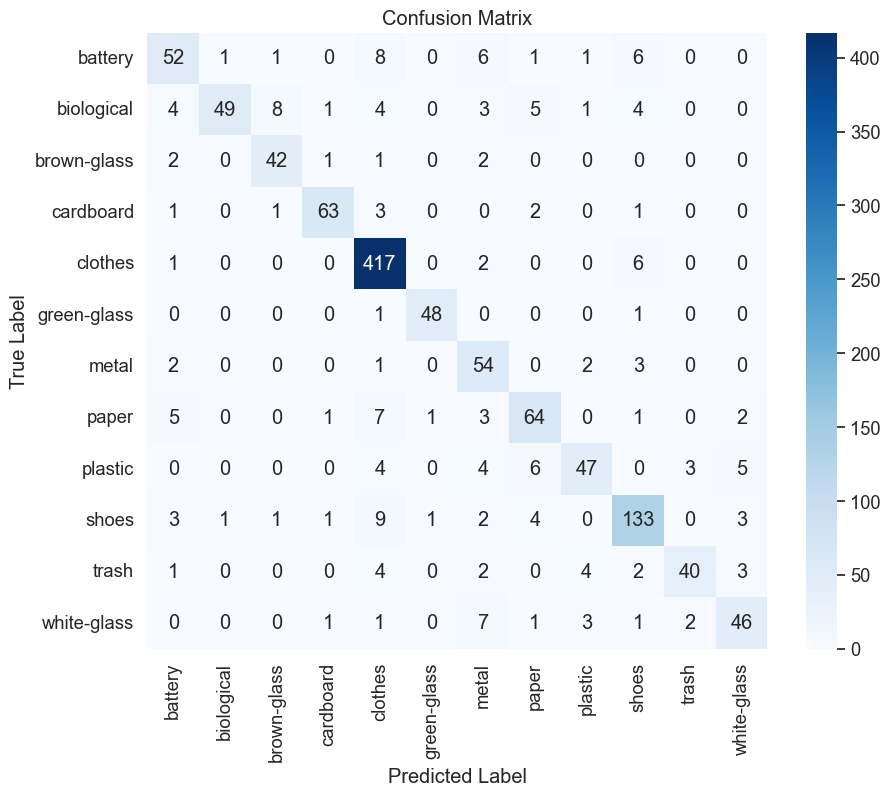

In [161]:
# Call the function to show the confusion matrix
plot_confusion_heatmap(best_model_50, eval_dir=[test_generator_dir_50], eval_name=["Test Data of 50x50px"])

# 10. Examples of images of wrong classifications

#### In this step, I look for incorrectly classified images to understand the reasons behind the misclassifications

Found 1241 images belonging to 12 classes.


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


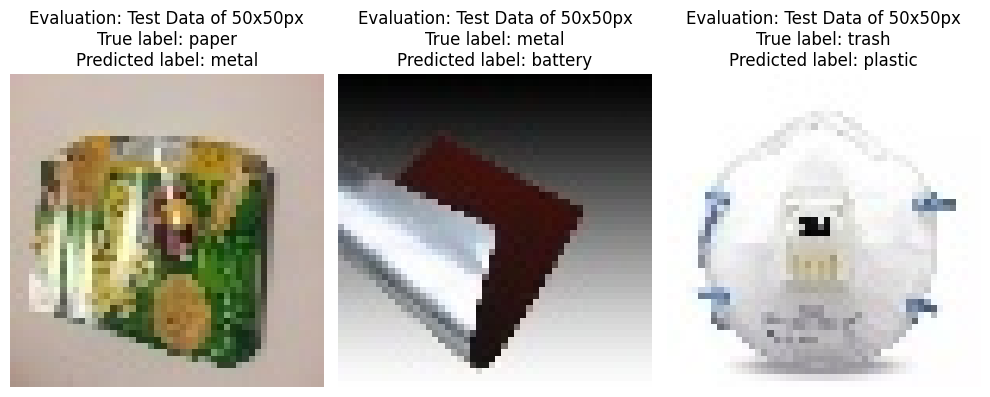

In [129]:
# Call the function to show images of wrong classifications
plot_wrong_classifications(model=best_model_50, test_directories=[test_generator_dir_50], eval_names=["Test Data of 50x50px"])